# XGBoost Stock Price Change Prediction Model
This notebook trains an XGBoost regression model to predict `percent_daily_price_change` using the feature set prepared in previous steps.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

/Users/jeffreyvananderson/stock_market_preds_v1/.venv_xgboostmodel/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv('processed_data/xgboost_feature_set/xgboost_feature_set.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (250167, 100)


,symbol,prediction_date,percent_daily_price_change,sd_open,sd_high,sd_low,sd_close,sd_volume,sd_vwap,sd_trade_count,...,fingpt_neutral_count,fingpt_negative_count,fingpt_total_articles,fingpt_avg_confidence,finbert_positive_count,finbert_neutral_count,finbert_negative_count,finbert_total_articles,finbert_avg_confidence,split
0,A,2025-01-07,-0.004939,137.68,137.68,135.630,137.00,1684573.0,137.068421,19948.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,A,2025-01-09,0.020186,134.75,140.14,134.709,137.47,1369875.0,137.592663,25383.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,A,2025-01-12,0.034470,137.22,142.82,137.000,141.95,1561959.0,141.776934,28739.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,A,2025-01-13,0.010070,142.00,145.38,140.150,143.43,2445434.0,143.373405,36636.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
4,A,2025-01-14,-0.013251,144.14,146.50,138.680,142.23,2328643.0,142.841548,35076.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [3]:
# Define columns
TARGET = 'percent_daily_price_change'
REFERENCE_COLS = ['symbol', 'prediction_date']
SPLIT_COL = 'split'

# Leaking features to exclude (same-day stock data used to compute target)
EXCLUDE_COLS = ['sd_open', 'sd_high', 'sd_low', 'sd_close', 'sd_volume', 'sd_vwap', 'sd_trade_count']

# Identify feature columns (exclude target, reference, split, and leaking features)
feature_cols = [c for c in df.columns if c not in [TARGET, SPLIT_COL] + REFERENCE_COLS + EXCLUDE_COLS]
print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Number of features: 89
Features: ['fin_days_since_release', 'ed_eps_estimate', 'ed_reported_eps', 'ed_surprise_pct', 'is_total_revenue', 'is_gross_profit', 'is_operating_income', 'is_net_income', 'is_ebitda', 'is_ebit', 'is_diluted_eps', 'is_basic_eps', 'is_cost_of_revenue', 'is_operating_expense', 'is_interest_expense', 'is_tax_provision', 'is_research_and_development', 'is_selling_general_admin', 'is_gross_margin', 'is_operating_margin', 'is_net_margin', 'bs_total_assets', 'bs_total_liabilities', 'bs_stockholders_equity', 'bs_total_debt', 'bs_net_debt', 'bs_cash_and_equivalents', 'bs_current_assets', 'bs_current_liabilities', 'bs_working_capital', 'bs_goodwill_intangibles', 'bs_net_ppe', 'bs_inventory', 'bs_accounts_receivable', 'bs_accounts_payable', 'bs_retained_earnings', 'bs_current_ratio', 'bs_debt_to_equity', 'cf_operating_cash_flow', 'cf_investing_cash_flow', 'cf_financing_cash_flow', 'cf_free_cash_flow', 'cf_capital_expenditure', 'cf_depreciation_amortization', 'cf_stock_base

In [4]:
# Diagnose missing data patterns
print("=== Missing Data Analysis ===\n")

# Check nulls per feature group
sentiment_cols = [c for c in df.columns if 'fingpt' in c or 'finbert' in c]
financial_cols = [c for c in df.columns if c.startswith(('is_', 'bs_', 'cf_', 'ed_', 'fin_'))]
econ_cols = [c for c in df.columns if c.startswith('econ_')]

print(f"Sentiment features null %: {df[sentiment_cols].isnull().mean().mean()*100:.1f}%")
print(f"Financial features null %: {df[financial_cols].isnull().mean().mean()*100:.1f}%")
print(f"Economic features null %: {df[econ_cols].isnull().mean().mean()*100:.1f}%")

# Check rows with/without sentiment
has_sentiment = (df['fingpt_total_articles'].notna() & (df['fingpt_total_articles'] > 0))
print(f"\nRows WITH sentiment: {has_sentiment.sum()} ({has_sentiment.mean()*100:.1f}%)")
print(f"Rows WITHOUT sentiment: {(~has_sentiment).sum()} ({(~has_sentiment).mean()*100:.1f}%)")

# Check rows with/without financials  
has_financials = df['is_total_revenue'].notna()
print(f"\nRows WITH financials: {has_financials.sum()} ({has_financials.mean()*100:.1f}%)")
print(f"Rows WITHOUT financials: {(~has_financials).sum()} ({(~has_financials).mean()*100:.1f}%)")

# Show pattern combinations
print("\n=== Data Availability Patterns ===")
df['has_sentiment'] = has_sentiment
df['has_financials'] = has_financials
pattern_counts = df.groupby(['has_sentiment', 'has_financials']).size().reset_index(name='count')
pattern_counts['pct'] = pattern_counts['count'] / len(df) * 100
print(pattern_counts)

=== Missing Data Analysis ===

Sentiment features null %: 91.4%
Financial features null %: 9.3%
Economic features null %: 0.0%

Rows WITH sentiment: 21584 (8.6%)
Rows WITHOUT sentiment: 228583 (91.4%)

Rows WITH financials: 246417 (98.5%)
Rows WITHOUT financials: 3750 (1.5%)

=== Data Availability Patterns ===
   has_sentiment  has_financials   count        pct
0          False           False    3541   1.415454
1          False            True  225042  89.956709
2           True           False     209   0.083544
3           True            True   21375   8.544292


In [5]:
# Split data into train and test based on 'split' column
train_df = df[df[SPLIT_COL] == 'train'].copy()
test_df = df[df[SPLIT_COL] == 'test'].copy()
print(f"Training set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

Training set: 199772 rows
Test set: 50395 rows


In [6]:
# Apply Min-Max scaling to continuous features (fit on train only)
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols].fillna(0))
test_df[feature_cols] = scaler.transform(test_df[feature_cols].fillna(0))

print("Min-Max scaling applied.")

Min-Max scaling applied.


In [7]:
# Prepare training data
X_train = train_df[feature_cols]
y_train = train_df[TARGET]
X_test = test_df[feature_cols]
y_test = test_df[TARGET]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (199772, 89), y_train: (199772,)
X_test: (50395, 89), y_test: (50395,)


In [8]:
# 5-Fold Cross Validation on training set
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, 
                          max_depth=6, random_state=42, n_jobs=-1)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rmse = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
cv_scores_mae = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
cv_scores_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')

print("5-Fold Cross Validation Results (Training Set):")
print(f"  RMSE: {cv_scores_rmse.mean():.6f} (+/- {cv_scores_rmse.std():.6f})")
print(f"  MAE:  {cv_scores_mae.mean():.6f} (+/- {cv_scores_mae.std():.6f})")
print(f"  R²:   {cv_scores_r2.mean():.6f} (+/- {cv_scores_r2.std():.6f})")

5-Fold Cross Validation Results (Training Set):
  RMSE: 0.018750 (+/- 0.000184)
  MAE:  0.012571 (+/- 0.000054)
  R²:   0.261082 (+/- 0.007220)


In [9]:
# Train final model on full training set
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'model_archive/xgboost_model.joblib')
print("Model trained and saved to model_archive/xgboost_model.joblib")

Model trained and saved to model_archive/xgboost_model.joblib


In [10]:
# Generate predictions
train_df['predicted'] = model.predict(X_train)
test_df['predicted'] = model.predict(X_test)

# Calculate metrics function
def calc_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {'Set': set_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

# Training and test metrics
metrics = [calc_metrics(y_train, train_df['predicted'], 'Train'),
           calc_metrics(y_test, test_df['predicted'], 'Test')]
metrics_df = pd.DataFrame(metrics)
print("Performance Metrics:")
metrics_df

Performance Metrics:


,Set,RMSE,MAE,R²,MAPE
0,Train,0.018065,0.012267,0.314154,184277.810232
1,Test,0.022006,0.015636,-0.204751,365697.127169


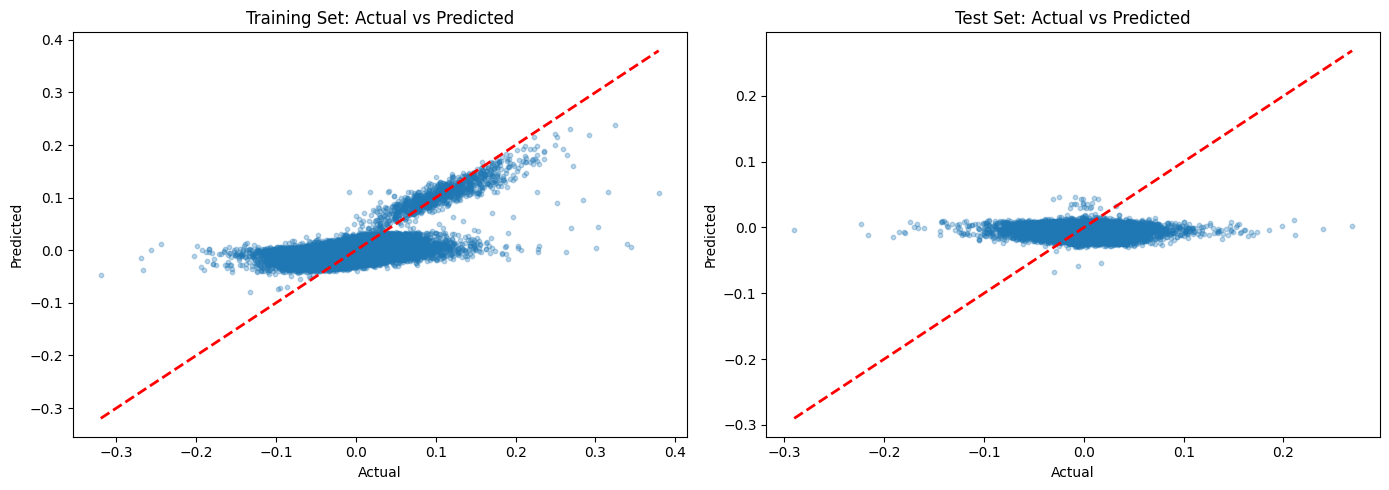

In [11]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df_plot, name) in zip(axes, [(train_df, 'Training'), (test_df, 'Test')]):
    ax.scatter(df_plot[TARGET], df_plot['predicted'], alpha=0.3, s=10)
    ax.plot([df_plot[TARGET].min(), df_plot[TARGET].max()], 
            [df_plot[TARGET].min(), df_plot[TARGET].max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name} Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

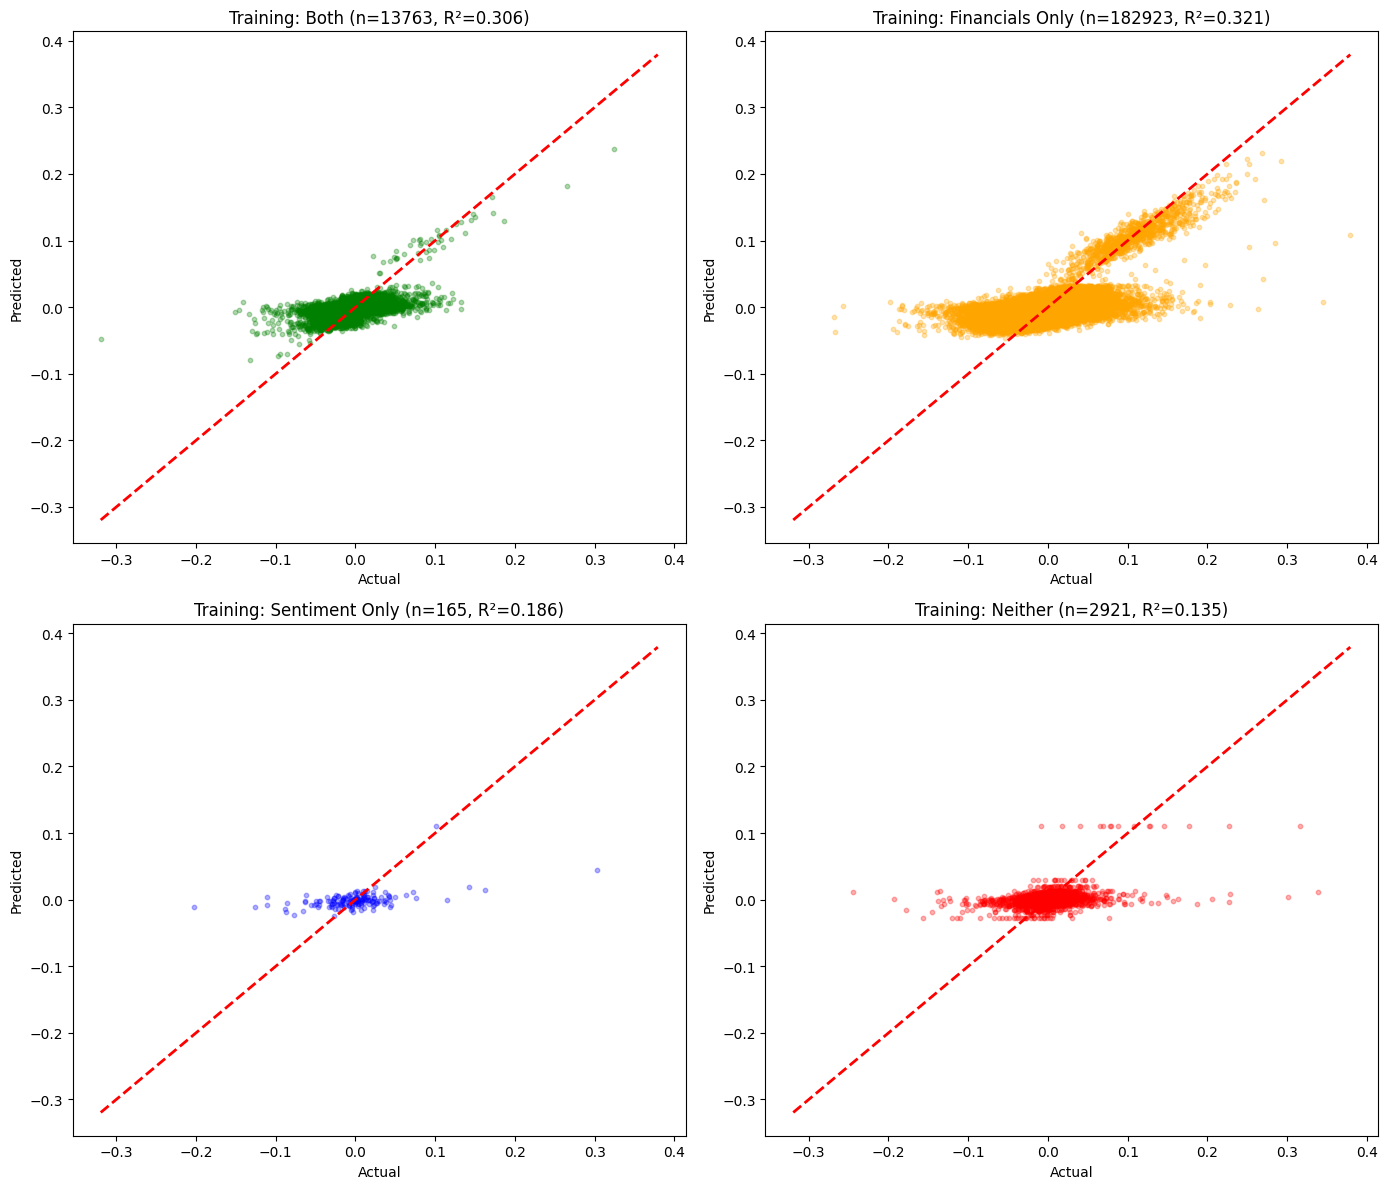


=== Performance by Data Availability Pattern (Training Set) ===
Both                : n= 13763, R²=0.3065, RMSE=0.018368
Financials Only     : n=182923, R²=0.3212, RMSE=0.017767
Sentiment Only      : n=   165, R²=0.1861, RMSE=0.043096
Neither             : n=  2921, R²=0.1346, RMSE=0.029271


In [12]:
# Visualization: Actual vs Predicted by data availability pattern
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Create pattern labels for train and test
for df_plot in [train_df, test_df]:
    df_plot['pattern'] = 'Neither'
    df_plot.loc[df_plot['has_sentiment'] & ~df_plot['has_financials'], 'pattern'] = 'Sentiment Only'
    df_plot.loc[~df_plot['has_sentiment'] & df_plot['has_financials'], 'pattern'] = 'Financials Only'
    df_plot.loc[df_plot['has_sentiment'] & df_plot['has_financials'], 'pattern'] = 'Both'

colors = {'Both': 'green', 'Sentiment Only': 'blue', 'Financials Only': 'orange', 'Neither': 'red'}

# Training set by pattern
for i, pattern in enumerate(['Both', 'Financials Only', 'Sentiment Only', 'Neither']):
    ax = axes[i // 2, i % 2]
    subset = train_df[train_df['pattern'] == pattern]
    if len(subset) > 0:
        ax.scatter(subset[TARGET], subset['predicted'], alpha=0.3, s=10, c=colors[pattern])
        ax.plot([train_df[TARGET].min(), train_df[TARGET].max()], 
                [train_df[TARGET].min(), train_df[TARGET].max()], 'r--', lw=2)
        r2 = r2_score(subset[TARGET], subset['predicted']) if len(subset) > 1 else 0
        ax.set_title(f'Training: {pattern} (n={len(subset)}, R²={r2:.3f})')
    else:
        ax.set_title(f'Training: {pattern} (n=0)')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Performance by Data Availability Pattern (Training Set) ===")
for pattern in ['Both', 'Financials Only', 'Sentiment Only', 'Neither']:
    subset = train_df[train_df['pattern'] == pattern]
    if len(subset) > 1:
        r2 = r2_score(subset[TARGET], subset['predicted'])
        rmse = np.sqrt(mean_squared_error(subset[TARGET], subset['predicted']))
        print(f"{pattern:20s}: n={len(subset):6d}, R²={r2:.4f}, RMSE={rmse:.6f}")

=== Investigating Two Clusters in Financials Only ===

1. Predictions Near Zero vs Not:
   pred_near_zero=True: n=182021, R²=0.2056, mean_pred=-0.0000
   pred_near_zero=False: n=   902, R²=0.6778, mean_pred=0.1087

2. Feature Differences (near-zero preds vs normal preds):

3. Symbol Distribution:
   Near-zero predictions: 182021 rows, 991 unique symbols
   Normal predictions: 902 rows, 895 unique symbols
   Symbols ONLY in near-zero group: 96

4. Financial Data Recency:
   Near-zero: mean fin_days_since_release = 0.1
   Normal: mean fin_days_since_release = 0.1


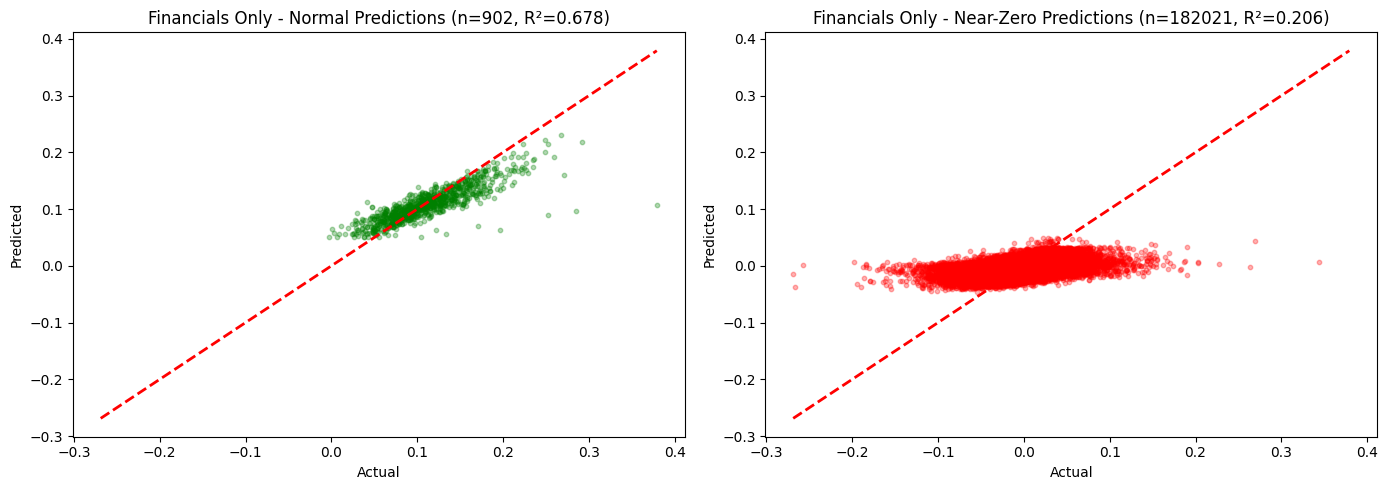

In [13]:
# Deep dive: Why two clusters in "Financials Only"?
fin_only = train_df[train_df['pattern'] == 'Financials Only'].copy()

print("=== Investigating Two Clusters in Financials Only ===\n")

# The flat cluster likely has predictions near 0 - let's check
fin_only['pred_near_zero'] = np.abs(fin_only['predicted']) < 0.05

print("1. Predictions Near Zero vs Not:")
for near_zero in [True, False]:
    subset = fin_only[fin_only['pred_near_zero'] == near_zero]
    if len(subset) > 1:
        r2 = r2_score(subset[TARGET], subset['predicted'])
        print(f"   pred_near_zero={near_zero}: n={len(subset):6d}, R²={r2:.4f}, mean_pred={subset['predicted'].mean():.4f}")

# What features differ between the two groups?
print("\n2. Feature Differences (near-zero preds vs normal preds):")
near_zero_group = fin_only[fin_only['pred_near_zero']]
normal_group = fin_only[~fin_only['pred_near_zero']]

# Compare means of key features
for col in feature_cols[:20]:  # Check first 20 features
    nz_mean = near_zero_group[col].mean()
    norm_mean = normal_group[col].mean()
    if abs(nz_mean - norm_mean) > 0.1:  # Only show significant differences
        print(f"   {col}: near_zero={nz_mean:.3f}, normal={norm_mean:.3f}")

# 3. Check if it's related to specific symbols
print("\n3. Symbol Distribution:")
nz_symbols = near_zero_group['symbol'].nunique()
norm_symbols = normal_group['symbol'].nunique()
print(f"   Near-zero predictions: {len(near_zero_group)} rows, {nz_symbols} unique symbols")
print(f"   Normal predictions: {len(normal_group)} rows, {norm_symbols} unique symbols")

# Are there symbols that are ONLY in near-zero group?
nz_only_symbols = set(near_zero_group['symbol'].unique()) - set(normal_group['symbol'].unique())
print(f"   Symbols ONLY in near-zero group: {len(nz_only_symbols)}")
if len(nz_only_symbols) > 0 and len(nz_only_symbols) <= 10:
    print(f"   {nz_only_symbols}")

# 4. Check fin_days_since_release distribution
print("\n4. Financial Data Recency:")
print(f"   Near-zero: mean fin_days_since_release = {near_zero_group['fin_days_since_release'].mean():.1f}")
print(f"   Normal: mean fin_days_since_release = {normal_group['fin_days_since_release'].mean():.1f}")

# 5. Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (subset, color, label) in zip(axes, [(normal_group, 'green', 'Normal Predictions'), 
                                              (near_zero_group, 'red', 'Near-Zero Predictions')]):
    ax.scatter(subset[TARGET], subset['predicted'], alpha=0.3, s=10, c=color)
    ax.plot([fin_only[TARGET].min(), fin_only[TARGET].max()], 
            [fin_only[TARGET].min(), fin_only[TARGET].max()], 'r--', lw=2)
    r2 = r2_score(subset[TARGET], subset['predicted']) if len(subset) > 1 else 0
    ax.set_title(f'Financials Only - {label} (n={len(subset)}, R²={r2:.3f})')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
plt.tight_layout()
plt.show()

In [14]:
# Investigate symbol-level patterns
print("=== Symbol-Level Analysis ===\n")

# Records per symbol in each group
nz_symbol_counts = near_zero_group.groupby('symbol').size().reset_index(name='near_zero_records')
norm_symbol_counts = normal_group.groupby('symbol').size().reset_index(name='normal_records')

# Merge to see full picture
symbol_analysis = nz_symbol_counts.merge(norm_symbol_counts, on='symbol', how='outer').fillna(0)
symbol_analysis['total'] = symbol_analysis['near_zero_records'] + symbol_analysis['normal_records']
symbol_analysis['pct_near_zero'] = symbol_analysis['near_zero_records'] / symbol_analysis['total'] * 100

print("1. Top 20 symbols by near-zero record count:")
top_nz = symbol_analysis.nlargest(20, 'near_zero_records')
print(top_nz[['symbol', 'near_zero_records', 'normal_records', 'pct_near_zero']].to_string())

print("\n2. Top 20 symbols by NORMAL record count:")
top_norm = symbol_analysis.nlargest(20, 'normal_records')
print(top_norm[['symbol', 'near_zero_records', 'normal_records', 'pct_near_zero']].to_string())

print("\n3. Symbols with HIGH near-zero % (>=90%):")
high_nz = symbol_analysis[symbol_analysis['pct_near_zero'] >= 90]
print(f"   Count: {len(high_nz)} symbols")
print(f"   Total records: {high_nz['near_zero_records'].sum():.0f}")

print("\n4. Symbols with LOW near-zero % (<=10%):")
low_nz = symbol_analysis[symbol_analysis['pct_near_zero'] <= 10]
print(f"   Count: {len(low_nz)} symbols")
print(f"   Total records: {low_nz['normal_records'].sum():.0f}")

# Load original data for raw feature comparison
df_raw = pd.read_csv('processed_data/xgboost_feature_set/xgboost_feature_set.csv')

# 5. High near-zero symbols raw feature patterns
print("\n5. Raw feature patterns for HIGH NEAR-ZERO symbols (>=90%):")
high_nz_symbols = high_nz['symbol'].head(5).tolist()
if high_nz_symbols:
    for sym in high_nz_symbols[:3]:
        sym_data = df_raw[df_raw['symbol'] == sym]
        print(f"\n   {sym}: {len(sym_data)} records")
        for col in ['is_total_revenue', 'bs_total_assets', 'econ_vix']:
            if col in df_raw.columns:
                print(f"      {col}: mean={sym_data[col].mean():.2e}, nulls={sym_data[col].isnull().sum()}")

# 6. Low near-zero symbols raw feature patterns
print("\n6. Raw feature patterns for LOW NEAR-ZERO symbols (<=10%):")
low_nz_symbols = low_nz['symbol'].head(5).tolist()
if low_nz_symbols:
    for sym in low_nz_symbols[:3]:
        sym_data = df_raw[df_raw['symbol'] == sym]
        print(f"\n   {sym}: {len(sym_data)} records")
        for col in ['is_total_revenue', 'bs_total_assets', 'econ_vix']:
            if col in df_raw.columns:
                print(f"      {col}: mean={sym_data[col].mean():.2e}, nulls={sym_data[col].isnull().sum()}")

# 7. Compare aggregate statistics between groups
print("\n7. Aggregate Raw Feature Comparison (High vs Low near-zero %):")
high_nz_list = high_nz['symbol'].tolist()
low_nz_list = low_nz['symbol'].tolist()

high_nz_raw = df_raw[df_raw['symbol'].isin(high_nz_list)]
low_nz_raw = df_raw[df_raw['symbol'].isin(low_nz_list)]

compare_cols = ['is_total_revenue', 'bs_total_assets', 'is_net_income', 'cf_operating_cash_flow', 'econ_high_yield_spread']
print(f"{'Feature':<30} {'High NZ Mean':>18} {'Low NZ Mean':>18} {'Ratio':>10}")
print("-" * 80)
for col in compare_cols:
    if col in df_raw.columns:
        high_mean = high_nz_raw[col].mean()
        low_mean = low_nz_raw[col].mean()
        ratio = high_mean / low_mean if low_mean != 0 else float('inf')
        print(f"{col:<30} {high_mean:>18.2e} {low_mean:>18.2e} {ratio:>10.2f}")

# 8. Date range analysis
print("\n8. Date Range by Prediction Group:")
print(f"   Near-zero: {near_zero_group['prediction_date'].min()} to {near_zero_group['prediction_date'].max()}")
print(f"   Normal: {normal_group['prediction_date'].min()} to {normal_group['prediction_date'].max()}")

=== Symbol-Level Analysis ===

1. Top 20 symbols by near-zero record count:
    symbol  near_zero_records  normal_records  pct_near_zero
158    CCC                199             1.0      99.500000
359   FISV                198             1.0      99.497487
387    GAP                197             1.0      99.494949
573    MDU                197             1.0      99.494949
6     ABNB                196             1.0      99.492386
143   CACC                196             1.0      99.492386
182     CI                196             1.0      99.492386
319   ERIE                196             1.0      99.492386
330     EW                196             1.0      99.492386
339   EXPE                196             1.0      99.492386
682   PATH                196             1.0      99.492386
856   TFSL                196             1.0      99.492386
234   CTAS                195             1.0      99.489796
375   FRHC                195             1.0      99.489796
424   HAY

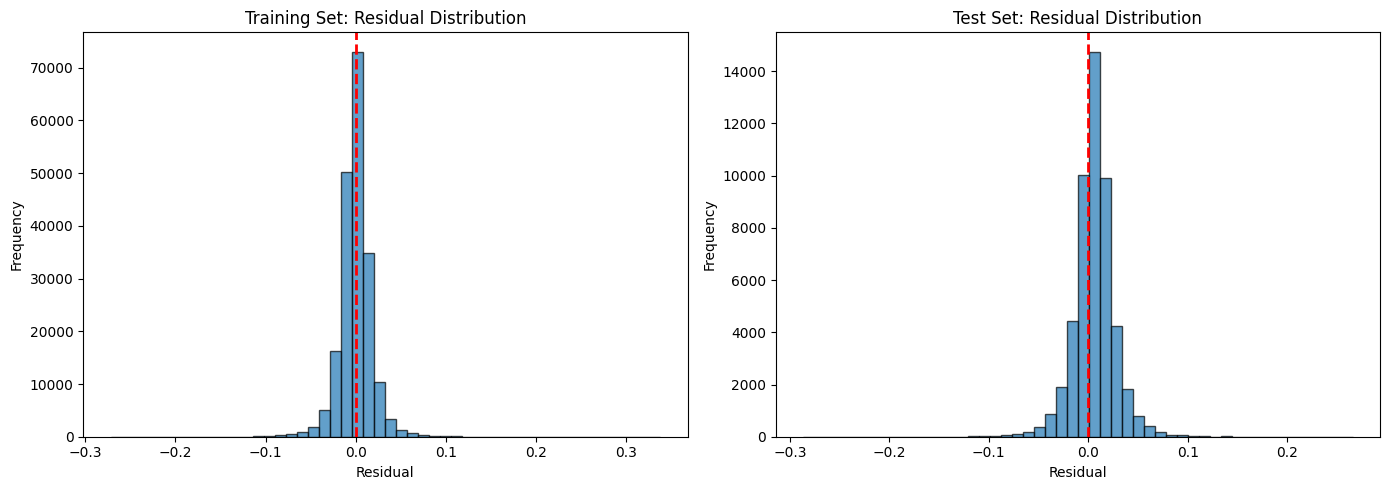

In [15]:
# Visualization: Residuals distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (df_plot, name) in zip(axes, [(train_df, 'Training'), (test_df, 'Test')]):
    residuals = df_plot[TARGET] - df_plot['predicted']
    ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} Set: Residual Distribution')

plt.tight_layout()
plt.show()

In [16]:
# Calculate SHAP values for all data (train + test)
explainer = shap.TreeExplainer(model)
all_df = pd.concat([train_df, test_df], ignore_index=True)
X_all = all_df[feature_cols]
shap_values = explainer.shap_values(X_all)

print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (250167, 89)


In [17]:
# Add SHAP values as columns to the dataframe
shap_df = pd.DataFrame(shap_values, columns=[f'shap_{c}' for c in feature_cols])
final_df = pd.concat([all_df.reset_index(drop=True), shap_df], axis=1)

# Reorder columns: reference cols, target, predicted, features, shap values
col_order = REFERENCE_COLS + [TARGET, 'predicted', SPLIT_COL] + feature_cols + list(shap_df.columns)
final_df = final_df[col_order]

print(f"Final dataframe shape: {final_df.shape}")
final_df.head()

Final dataframe shape: (250167, 183)


,symbol,prediction_date,percent_daily_price_change,predicted,split,fin_days_since_release,ed_eps_estimate,ed_reported_eps,ed_surprise_pct,is_total_revenue,...,shap_fingpt_positive_count,shap_fingpt_neutral_count,shap_fingpt_negative_count,shap_fingpt_total_articles,shap_fingpt_avg_confidence,shap_finbert_positive_count,shap_finbert_neutral_count,shap_finbert_negative_count,shap_finbert_total_articles,shap_finbert_avg_confidence
0,A,2025-01-07,-0.004939,0.002752,train,0.031390,0.128296,0.292039,0.773163,0.011645,...,0.0,-6.032099e-08,3.853295e-09,-3.246293e-08,-5.076721e-08,1.316738e-07,2.152690e-07,-5.286411e-07,0.0,0.000054
1,A,2025-01-09,0.020186,-0.004955,train,0.032885,0.128296,0.292039,0.773163,0.011645,...,0.0,1.080959e-06,3.853295e-09,-3.246293e-08,-5.076721e-08,1.316738e-07,2.154152e-07,-5.286411e-07,0.0,0.000050
2,A,2025-01-12,0.034470,0.006688,train,0.035127,0.128296,0.292039,0.773163,0.011645,...,0.0,1.062086e-06,3.853295e-09,-3.246293e-08,-5.076721e-08,1.316738e-07,2.154152e-07,-5.286411e-07,0.0,0.000052
3,A,2025-01-13,0.010070,0.006688,train,0.035874,0.128296,0.292039,0.773163,0.011645,...,0.0,1.062086e-06,3.853295e-09,-3.246293e-08,-5.076721e-08,1.519655e-07,2.154152e-07,-5.286411e-07,0.0,0.000052
4,A,2025-01-14,-0.013251,-0.006135,train,0.036622,0.128296,0.292039,0.773163,0.011645,...,0.0,1.062086e-06,3.853295e-09,-3.246293e-08,-5.076721e-08,1.519655e-07,2.154152e-07,-5.286411e-07,0.0,0.000034


In [18]:
# Export predictions with SHAP values
final_df.to_csv('processed_data/xgboost_predictions_with_shap.csv', index=False)

# Export SHAP values separately
shap_export = pd.concat([all_df[REFERENCE_COLS + [SPLIT_COL]].reset_index(drop=True), shap_df], axis=1)
shap_export.to_csv('processed_data/shap_values.csv', index=False)

print("Exported: processed_data/xgboost_predictions_with_shap.csv")
print("Exported: processed_data/shap_values.csv")

Exported: processed_data/xgboost_predictions_with_shap.csv
Exported: processed_data/shap_values.csv


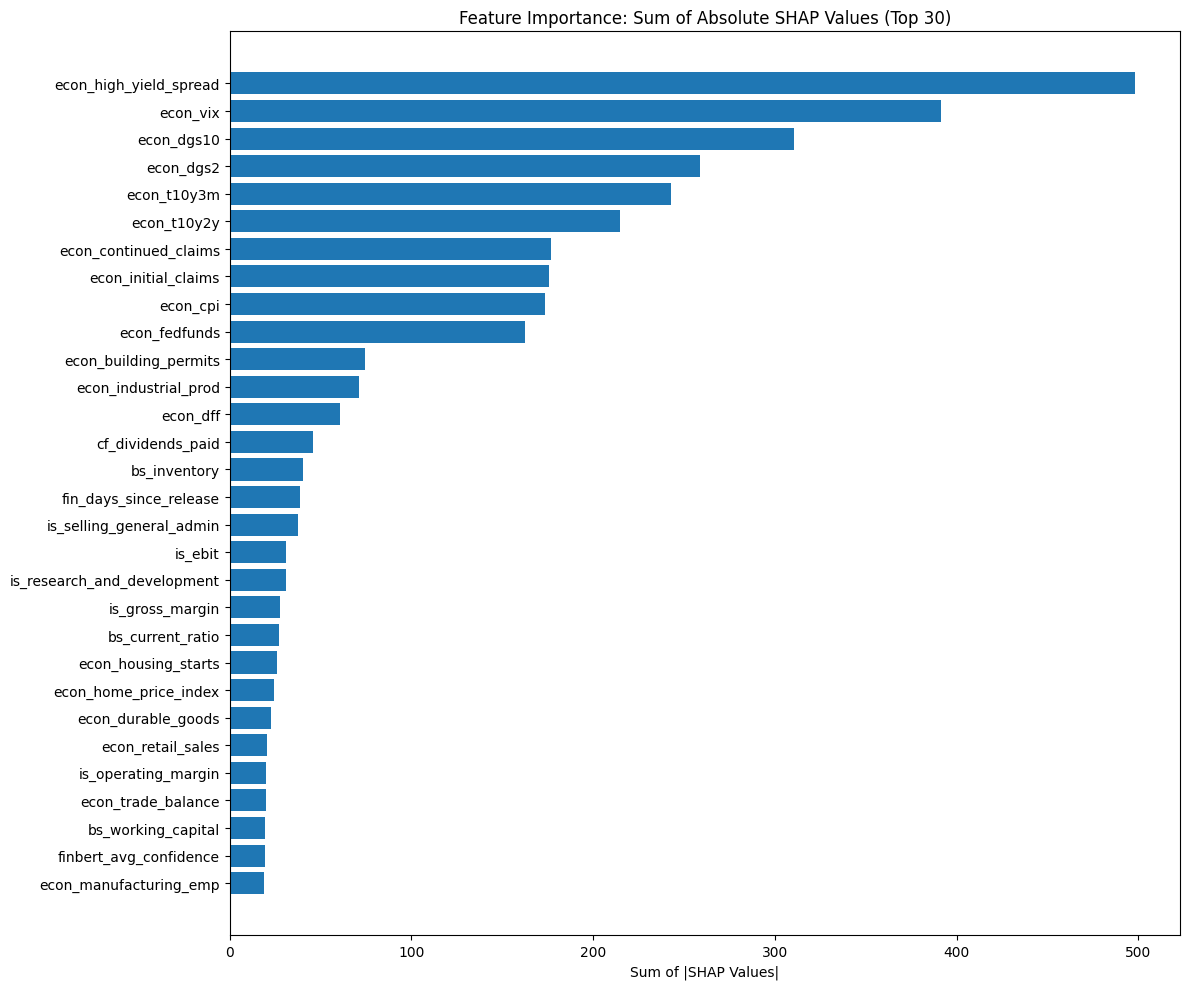

In [19]:
# Sum of SHAP values per feature (absolute importance)
shap_sum = np.abs(shap_values).sum(axis=0)
shap_sum_df = pd.DataFrame({'feature': feature_cols, 'shap_sum': shap_sum})
shap_sum_df = shap_sum_df.sort_values('shap_sum', ascending=False)

# Visualization: Sum of absolute SHAP values per feature
plt.figure(figsize=(12, 10))
plt.barh(shap_sum_df['feature'].head(30), shap_sum_df['shap_sum'].head(30))
plt.gca().invert_yaxis()
plt.xlabel('Sum of |SHAP Values|')
plt.title('Feature Importance: Sum of Absolute SHAP Values (Top 30)')
plt.tight_layout()
plt.show()

=== SHAP Comparison: High Predictions (>=0.05) vs Near-Zero (<0.05) ===

1. Summary Statistics:
   High predictions (|pred| >= 0.05): 968 records
   Near-zero predictions (|pred| < 0.05): 198,804 records
   High pred unique symbols: 955
   Near-zero unique symbols: 1007

2. Top 20 Features by SHAP Importance (High Pred Group):
                        feature  high_pred_shap_sum  low_pred_shap_sum  high_pred_pct  low_pred_pct
77       econ_high_yield_spread          106.771927         283.135437      73.712814     11.594713
46            cf_dividends_paid            3.589940          30.957888       2.478410      1.267760
17     is_selling_general_admin            2.181959          24.566082       1.506373      1.006009
16  is_research_and_development            1.980343          20.969437       1.367182      0.858722
78                     econ_vix            1.909189         316.800842       1.318059     12.973349
9                       is_ebit            1.559447          17.143343 

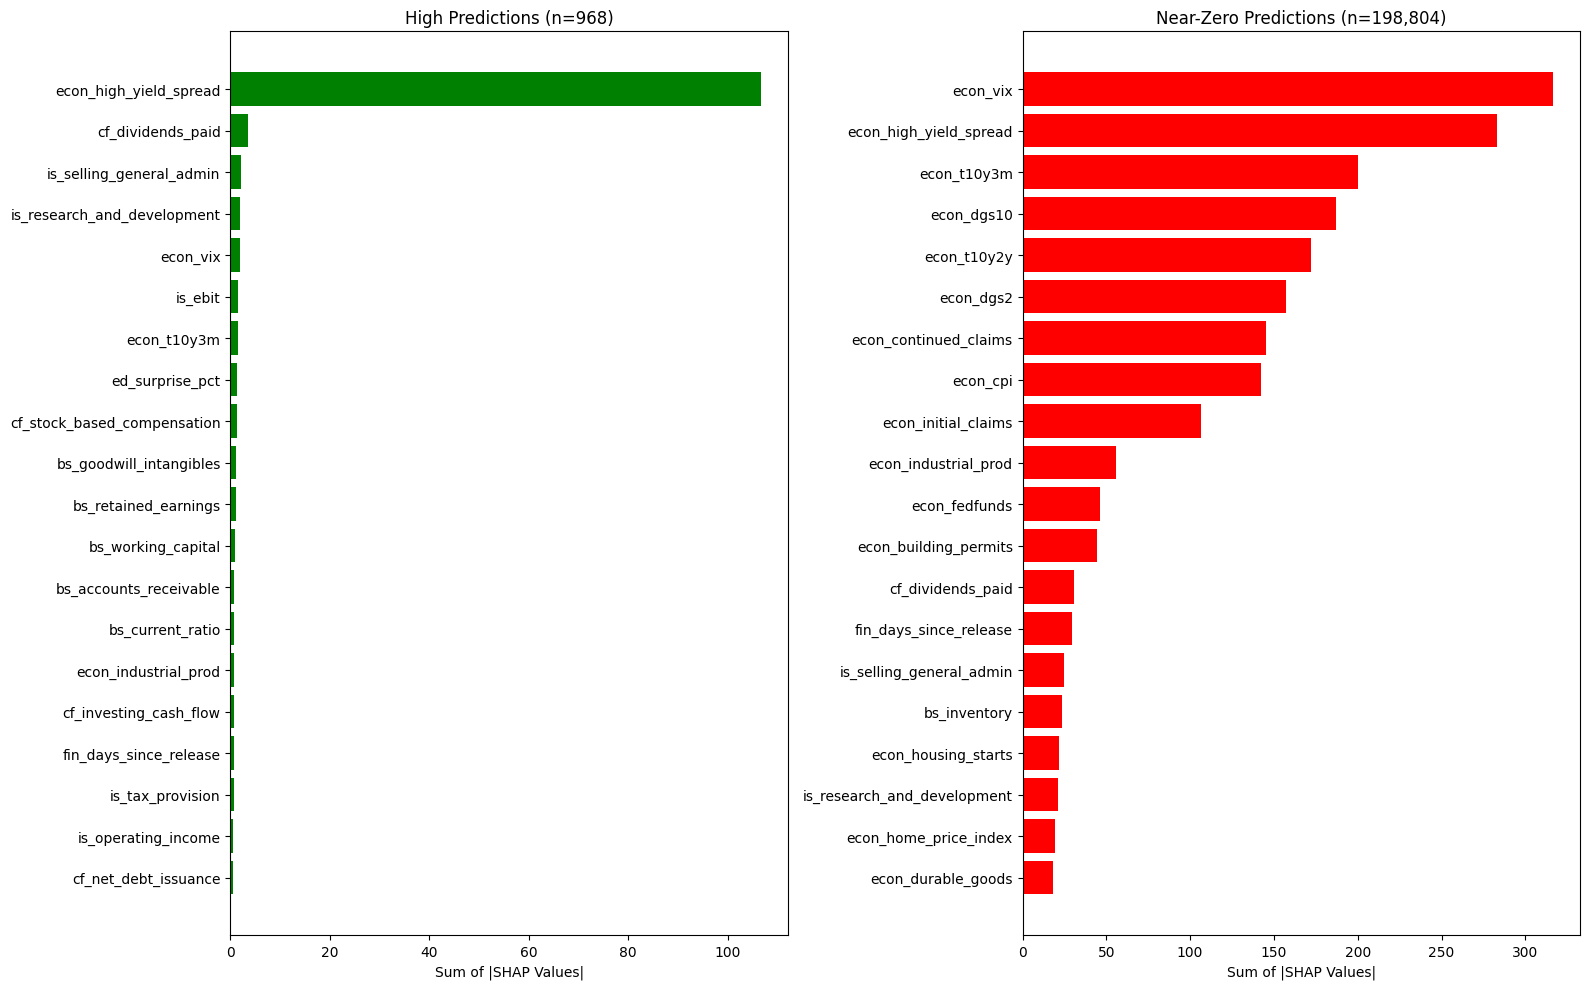

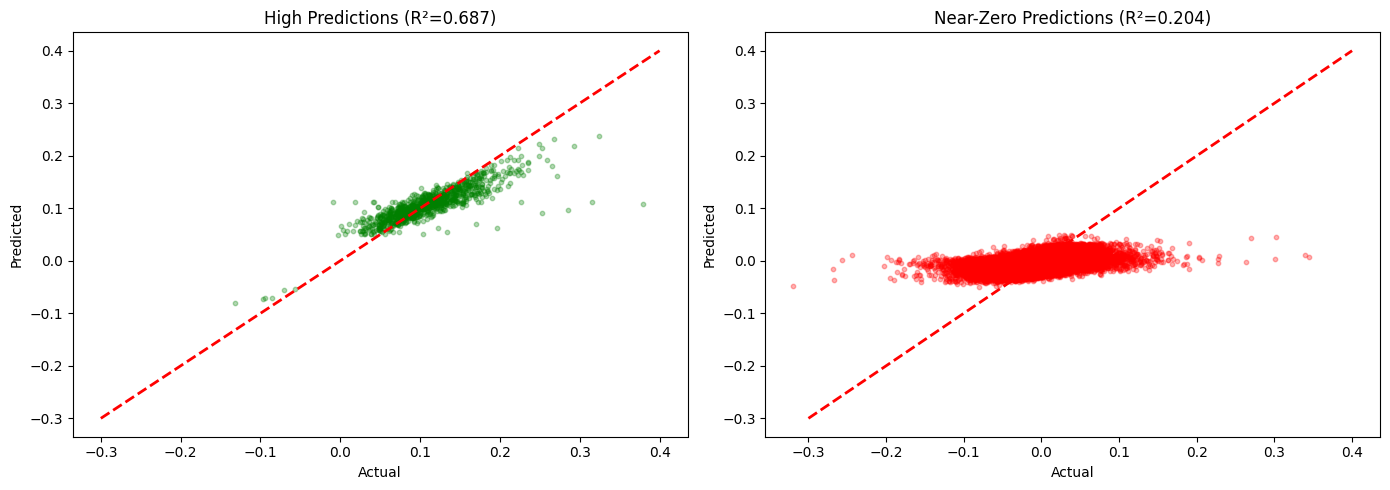

In [20]:
# SHAP Analysis: Compare high prediction vs near-zero prediction groups (Training Set Only)
print("=== SHAP Comparison: High Predictions (>=0.05) vs Near-Zero (<0.05) ===\n")

# Get training set indices in all_df
train_mask = all_df[SPLIT_COL] == 'train'
train_indices = np.where(train_mask)[0]

# Split training data by prediction magnitude
train_preds = all_df.loc[train_mask, 'predicted'].values
high_pred_mask = np.abs(train_preds) >= 0.05
low_pred_mask = np.abs(train_preds) < 0.05

high_pred_indices = train_indices[high_pred_mask]
low_pred_indices = train_indices[low_pred_mask]

# Summary stats
print("1. Summary Statistics:")
print(f"   High predictions (|pred| >= 0.05): {len(high_pred_indices):,} records")
print(f"   Near-zero predictions (|pred| < 0.05): {len(low_pred_indices):,} records")
print(f"   High pred unique symbols: {all_df.iloc[high_pred_indices]['symbol'].nunique()}")
print(f"   Near-zero unique symbols: {all_df.iloc[low_pred_indices]['symbol'].nunique()}")

# SHAP values for each group
shap_high = shap_values[high_pred_indices]
shap_low = shap_values[low_pred_indices]

# Sum of absolute SHAP values by feature for each group
shap_sum_high = np.abs(shap_high).sum(axis=0)
shap_sum_low = np.abs(shap_low).sum(axis=0)

shap_comparison = pd.DataFrame({
    'feature': feature_cols,
    'high_pred_shap_sum': shap_sum_high,
    'low_pred_shap_sum': shap_sum_low
})
shap_comparison['high_pred_pct'] = shap_comparison['high_pred_shap_sum'] / shap_comparison['high_pred_shap_sum'].sum() * 100
shap_comparison['low_pred_pct'] = shap_comparison['low_pred_shap_sum'] / shap_comparison['low_pred_shap_sum'].sum() * 100
shap_comparison['pct_diff'] = shap_comparison['high_pred_pct'] - shap_comparison['low_pred_pct']
shap_comparison = shap_comparison.sort_values('high_pred_shap_sum', ascending=False)

print("\n2. Top 20 Features by SHAP Importance (High Pred Group):")
print(shap_comparison[['feature', 'high_pred_shap_sum', 'low_pred_shap_sum', 'high_pred_pct', 'low_pred_pct']].head(20).to_string())

# Visualization: Side-by-side SHAP importance
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# High predictions
ax = axes[0]
top_features = shap_comparison.head(20)
ax.barh(top_features['feature'], top_features['high_pred_shap_sum'], color='green')
ax.invert_yaxis()
ax.set_xlabel('Sum of |SHAP Values|')
ax.set_title(f'High Predictions (n={len(high_pred_indices):,})')

# Low predictions
ax = axes[1]
shap_low_sorted = shap_comparison.sort_values('low_pred_shap_sum', ascending=False).head(20)
ax.barh(shap_low_sorted['feature'], shap_low_sorted['low_pred_shap_sum'], color='red')
ax.invert_yaxis()
ax.set_xlabel('Sum of |SHAP Values|')
ax.set_title(f'Near-Zero Predictions (n={len(low_pred_indices):,})')

plt.tight_layout()
plt.show()

# Scatter plot: Actual vs Predicted for both groups
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

high_df = all_df.iloc[high_pred_indices]
low_df = all_df.iloc[low_pred_indices]

ax = axes[0]
ax.scatter(high_df[TARGET], high_df['predicted'], alpha=0.3, s=10, c='green')
ax.plot([-0.3, 0.4], [-0.3, 0.4], 'r--', lw=2)
r2_high = r2_score(high_df[TARGET], high_df['predicted'])
ax.set_title(f'High Predictions (R²={r2_high:.3f})')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

ax = axes[1]
ax.scatter(low_df[TARGET], low_df['predicted'], alpha=0.3, s=10, c='red')
ax.plot([-0.3, 0.4], [-0.3, 0.4], 'r--', lw=2)
r2_low = r2_score(low_df[TARGET], low_df['predicted'])
ax.set_title(f'Near-Zero Predictions (R²={r2_low:.3f})')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

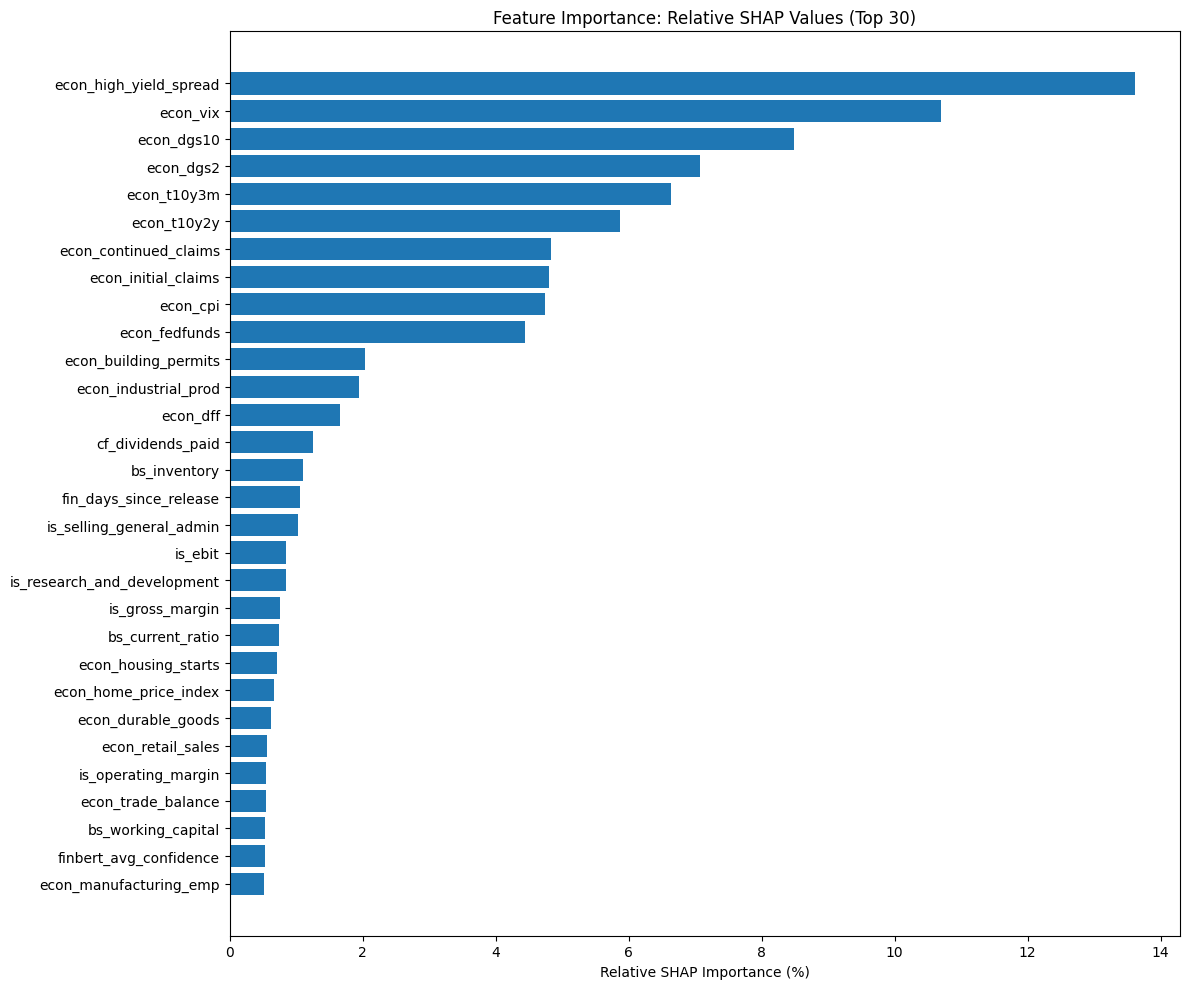

,feature,shap_sum,shap_relative
77,econ_high_yield_spread,497.954346,13.610226
78,econ_vix,391.429901,10.698669
52,econ_dgs10,310.292786,8.481008
53,econ_dgs2,258.523254,7.066029
55,econ_t10y3m,242.621338,6.631393
54,econ_t10y2y,214.865265,5.872756
63,econ_continued_claims,176.700378,4.829624
62,econ_initial_claims,175.755371,4.803794
56,econ_cpi,173.354706,4.738178
50,econ_fedfunds,162.312469,4.436369


In [21]:
# Relative SHAP values (percentage of total importance)
shap_sum_df['shap_relative'] = shap_sum_df['shap_sum'] / shap_sum_df['shap_sum'].sum() * 100

# Visualization: Relative SHAP importance per feature
plt.figure(figsize=(12, 10))
plt.barh(shap_sum_df['feature'].head(30), shap_sum_df['shap_relative'].head(30))
plt.gca().invert_yaxis()
plt.xlabel('Relative SHAP Importance (%)')
plt.title('Feature Importance: Relative SHAP Values (Top 30)')
plt.tight_layout()
plt.show()

# Display top features
shap_sum_df.head(20)

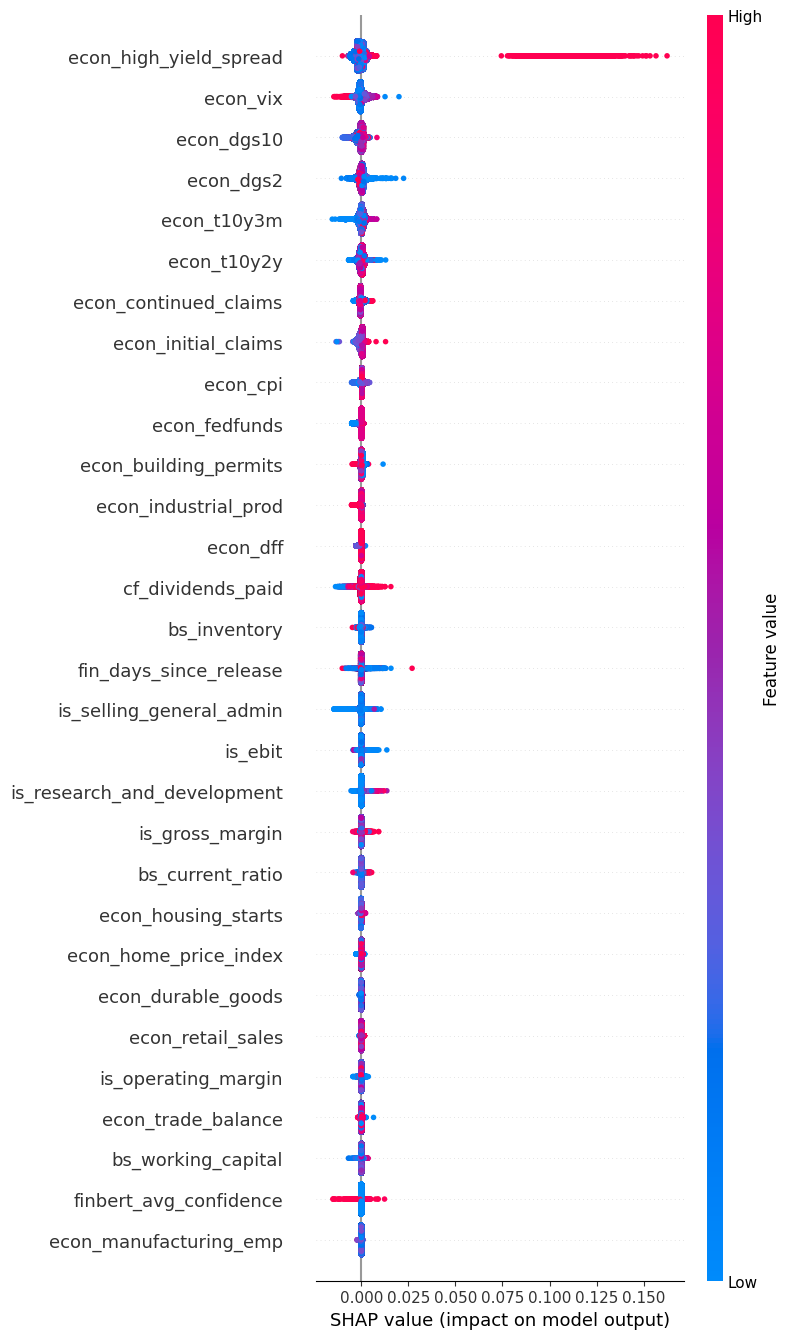

In [22]:
# SHAP Summary Plot (beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_all, feature_names=feature_cols, show=False, max_display=30)
plt.tight_layout()
plt.show()

In [23]:
# Export summary
print("=" * 60)
print("XGBoost Model Training Complete")
print("=" * 60)
print(f"\nModel saved: model_archive/xgboost_model.joblib")
print(f"Predictions with SHAP: processed_data/xgboost_predictions_with_shap.csv")
print(f"SHAP values only: processed_data/shap_values.csv")

XGBoost Model Training Complete

Model saved: model_archive/xgboost_model.joblib
Predictions with SHAP: processed_data/xgboost_predictions_with_shap.csv
SHAP values only: processed_data/shap_values.csv
